In [1]:
import numpy as np
import torch
import torch.utils.data as utils
from albumentations import (HorizontalFlip, VerticalFlip)
import random
import torchvision.transforms.functional as TF
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
import nibabel as nib
now=time.localtime(time.time())

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,i,data_path, augmentation=True):
        self.data_path = data_path
        self.data = np.load(data_path+'MRimages_{}.npy'.format(i))
        self.target = np.load(data_path+'MASK_{}.npy'.format(i))
        self.augmentation = augmentation
        print(self.data.shape)
        print(self.target.shape)
        
    def __getitem__(self, index):
        x= self.data[index]
        y = self.target[index]
        x,y=self.transform(x,y)
        
        return x,y
    
    def transform(self, data, target):
        data, target = data_augmentation(data, target, self.augmentation)
        return data, target
    
    def __len__(self):
        return len(self.data)


In [3]:
def data_augmentation(image, labels, aug=True):
    a= random.random()
    image = Image.fromarray(image)
    mask = Image.fromarray(labels)
    if aug :
        if a > 0.5 :
            augmentated = HorizontalFlip(p=1)(image=np.array (image), mask=np.array(mask))
            image = Image.fromarray(augmentated['image'])
            mask = Image.fromarray(augmentated['mask'])
    data = TF.to_tensor(np.array(image)).float()
    masks = TF.to_tensor(np.array(mask)).float()
    return data, masks

In [4]:
##==============전체 패러미터 입력창 ====================================##

number_of_p=5  # 전체 데이터셋 개수
img_size = 256 # 3d 복셀이 img_size x img_size x img_size 로 되있다고 생각한다. 
batch_size=4 # 배치 사이즈 
in_dim = 1 # 데이터 한개의 채널 개수. MR은 흑백 이미지 이므로 채널이 한개이다. 
out_dim = num_class = 6 # 총 분할해야 하는 클래스의 개수. 일단 여기서는 6종류 이므로 6개 이다. 
num_filters = 64 # 필터개수 
num_epoch = 100 # 트레이닝 횟수 
lr = 0.001 # learning rate

loss_func_switch = 2
'''0 = MSE Loss
   1 = Cross Entropy Loss
   2 = Dice Loss  다이스 로스는 폐기... 멀티 클래스 문제에서 이건 안됨 '''

##=======================================================================##

'0 = MSE Loss\n   1 = Cross Entropy Loss\n   2 = Dice Loss  다이스 로스는 폐기... 멀티 클래스 문제에서 이건 안됨 '

In [5]:
train_datasets=[]
test_datasets=[]

for i in range(1,number_of_p+1):
    if i == number_of_p : 
        test_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = False))
    else:
        train_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = True))

traindataset = torch.utils.data.ConcatDataset(train_datasets)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size =batch_size, shuffle = True, num_workers=0, pin_memory=False)

testdataset = torch.utils.data.ConcatDataset(test_datasets)
testloader = torch.utils.data.DataLoader(testdataset, batch_size =1, shuffle = False, num_workers=0, pin_memory=False)


(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)


In [6]:
'''
for batch_idx,(data,target) in enumerate(trainloader):
    inputs, target = data, target
    inputs=inputs.squeeze()
    target=inputs.squeeze()
    print('inputs=%s'%str(inputs.shape))
    print('target=%s'%str(target.shape))
#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
#print(inputs[0][0])
#f.write(inputs[0][0])

f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
line=''
enter='\n'
space=' '
for i in list(inputs[0][0]):
    line=''
    for j in list(i):
        line+=str(int(j))
        line+=space
    line+=enter
    f.write(line)
    '''

"\nfor batch_idx,(data,target) in enumerate(trainloader):\n    inputs, target = data, target\n    inputs=inputs.squeeze()\n    target=inputs.squeeze()\n    print('inputs=%s'%str(inputs.shape))\n    print('target=%s'%str(target.shape))\n#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\n#print(inputs[0][0])\n#f.write(inputs[0][0])\n\nf=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\nline=''\nenter='\n'\nspace=' '\nfor i in list(inputs[0][0]):\n    line=''\n    for j in list(i):\n        line+=str(int(j))\n        line+=space\n    line+=enter\n    f.write(line)\n    "

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model     

In [9]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn) # 필터갯수를 두개씩 늘린다. 
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn) #이게 업 스케일링 하는 거다. 
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn) # 이게 옆에있는 친구 끌고와서 같이 컴볼루젼 하는것, res 넷의 핵심 
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1))
            #nn.Softmax(dim=1))  
            #nn.Tanh()) 필수는 아님 시그모이드 함수와 유사하지만, -1~1까지 출력 범위하는 것이 다르다. 
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [10]:
def DC(number, m1, m2): # dice score 함수 이다.  넘버는 보고싶은 세크먼테이션의 넘버링이며,  int임  
    smooth = 1. 
    num = m1.size(0)
    num2 = m1.size(1)
    mx =  np.full((num,num2), number, dtype = np.int64)
    mx = TF.to_tensor(mx).squeeze().to(device=device, dtype=torch.int64)
    
    
    mx_m1 = mx==m1
    mx_m1 = mx_m1.float()
    mx_m2 = mx==m2
    mx_m2 = mx_m2.float()
    cross_m1_m2 = mx_m1==mx_m2 # 0과 1 둘다 겹치는 부분을 True로 출력함 
    
    zero_cross_m1_m2 = mx_m1==-1*mx_m2 #0 인데 겹치는 부분만 추출하기 위해서 만든거
    
    #print(mx_m1.float().sum(),mx_m2.float().sum(), cross_m1_m2.float().sum())
    #print(cross_m1_m2.float().sum()-zero_cross_m1_m2.float().sum())
    
    dc =  (2*(cross_m1_m2.float().sum()-zero_cross_m1_m2.float().sum())+smooth)/(mx_m1.sum()+mx_m2.sum()+smooth)
    return dc 
    
def DC_zero(number, m1, m2): # dice score 함수중 0부분에 해당하는 함수 이다.  넘버는 보고싶은 세크먼테이션의 넘버링이며,  int임  
    smooth = 1. 
    num = m1.size(0)
    num2 = m1.size(1)
    mx =  np.full((num,num2), number, dtype = np.int64)
    mx = TF.to_tensor(mx).squeeze().to(device=device, dtype=torch.int64)
    
    mx_m1 = mx==m1
    mx_m1 = mx_m1.float()
    mx_m2 = mx==m2
    mx_m2 = mx_m2.float()
    cross_m1_m2 = m1==100*m2 # m2에 100을 곱하면 나머지 클래스들은 절대 같을수가 없다. 때문에 원래 이미지에서 0끼리겹치는 부분만 나옴    
    
    #print(mx_m1.sum(),mx_m2.sum(), cross_m1_m2.float().sum())
    
    dc =  (2*cross_m1_m2.float().sum()+smooth)/(mx_m1.sum()+mx_m2.sum()+smooth)
    return dc 

In [11]:
class MSE_Loss(nn.Module):
    # y= [4,256,256] , output = [4,6,256,256]
    def __init__(self):
        super(MSE_Loss,self).__init__()
        pass
    
    def forward (self, output, y):
        soft_max = nn.Softmax(dim =1)
        output2 = soft_max(output).to (device)
        output2 = output2.permute(0,2,3,1).contiguous().to (device) # 차원을 바꿀때에는 transpose 나 permute를 사용한다. 
        
        one_hot = torch.zeros(batch_size, img_size, img_size, num_class).to (device)
        y2 = y.unsqueeze(3).to (device)
        y3 = one_hot.scatter_(3, y2, 1). to (device) 
        # 3이 들어간 이유는 scatter_에서 차원을 맞춰줘야하기 때문이다. [4,256,256,6], [4,256,256,1]의 다른 부분은 dim=3 이기 떄문. 
        loss = nn.MSELoss()(output2, y3).to (device) 
        return loss
    
class Dice_Loss(nn.Module): # 3d 상황에서 지켜봐야 할듯 하다... 
    # y= [4,256,256] , output = [4,6,256,256]
    def __init__(self):
        super(Dice_Loss,self).__init__()
        pass
    
    def forward (self, output, y):
        smooth = 1. 
        
        soft_max = nn.Softmax(dim =1)
        output2 = soft_max(output).to (device)
        output2 = output2.permute(1,0,2,3).contiguous().to (device)
        #output2=[6,4,256,256]
        self.output2 = output2
        self.y = y
        
        k_list=[]
        w_list = []
        loss=1.
        #tt=0
        for i in range (0,num_class):
            if i ==0 :
                #sum_p, mul, w = self.dice_zero(i)
                sum_p, mul, w = self.dice(i)
                k = (2*(mul)+smooth)/(sum_p+smooth)
                k_list.append(k)
                w_list.append(k)
                loss-=k/num_class
    
            else:
                sum_p, mul, w = self.dice(i)
                k = (2*(mul)+smooth)/(sum_p+smooth)
                k_list.append(k)
                w_list.append(k)
                loss-=k/num_class
                
        k_tensor = torch.FloatTensor(k_list)
        w_tensor = torch.FloatTensor(w_list)
        #loss-= (1/k_tensor.sum())*(w_tensor*k_tensor).sum()
            #w_list.append(w)
               
            #tt+=a
        #print(tt)
       
       # sum_p_tensor= torch.FloatTensor(sum_p_list).to(device)
       # mul_tensor = torch.FloatTensor(mul_list).to(device)
       # w_tensor = torch.FloatTensor(w_list).to(device)
        
        #loss =  1. - (2*(mul_tensor).sum()+smooth)/((sum_p_tensor).sum()+smooth)
        #loss.requires_grad=True # loss 를 float 으로 출력하게 되는데 이는 TRUE 가 아니라서 문제가 된다. 
        return loss
    
    def dice(self, i): # i 는 해당 클래스의 넘버 
        output_i = self.output2[i]#output_i = [4,256,256] 각 픽셀이 클래스 i 에 해당될 확률임 
        
        num, num2, num3 = self.y.size(0), self.y.size(1), self.y.size(2)
        mx =  np.full((num,num2,num3), i, dtype = np.int64)
        mx = torch.FloatTensor(mx).to(device)
    
        mx_y = mx==self.y
        mx_y = mx_y.float()
        
        sum_p = mx_y.sum() + output_i.sum()
        mul = (mx_y*output_i).sum()
        w= batch_size*img_size*img_size/(mx_y.sum()+1.)
        #w= batch_size*img_size*img_size/(num_class*mx_y.sum()+1.)
        #w = 1/((mx_y.sum())**(2)+1.)
        a = output_i.sum()
        
        return sum_p, mul, w  # , a
    
    def dice_zero(self, i): # i=0 일때 따로 돌린다. 백르라운드 자체가 너무 많기 때문에.. 
        output_i = self.output2[i]#output_i = [4,256,256] 각 픽셀이 클래스 i 에 해당될 확률임 
        
        num, num2, num3 = self.y.size(0), self.y.size(1), self.y.size(2)
        mx =  np.full((num,num2,num3), i, dtype = np.int64)
        mx = torch.FloatTensor(mx).to(device)
    
        mx_y = mx==self.y
        mx_y = mx_y.float()
        
        sum_p = (2.-mx_y - output_i).sum()
        mul = ((1.-mx_y)*(1.-output_i)).sum()
        w= batch_size*img_size*img_size/(mx_y.sum()+1.)
        #w = 1/((mx_y.sum())**(2)+1.)
        a = output_i.sum()
        return sum_p, mul, w

In [12]:
def check_output(i, x, y, output, export):
    zeros=np.zeros((img_size,img_size,1))
    x_sample=x[i].cpu()/256
    y_sample=y[i].cpu()*50/256
    output_sample=output[i].cpu()*50/256 
        
    x_sample2=np.reshape(x_sample, (img_size, img_size, 1))
    y_sample2=np.reshape(y_sample, (img_size, img_size, 1))
    ouput_sample2 = np.reshape(output_sample,(img_size,img_size,1))

    x_image=np.concatenate((x_sample2, x_sample2, x_sample2), axis = 2)
    y_image=np.concatenate(( zeros, y_sample2,  zeros), axis = 2)
    output_image=np.concatenate(( zeros, ouput_sample2, zeros), axis = 2)
        
    origin_image = x_image+y_image
    AI_image = x_image+output_image

    plt.subplot(131)
    plt.imshow(x_image)
    plt.subplot(132)
    plt.imshow(y_image)
    plt.subplot(133)
    plt.imshow(output_image)
        
    if export == True : 
        plt.savefig('C:/Users/BMPL/Desktop/test_{}.png'.format(i) , dpi=300)
    plt.show()

총 배치의 수 : 256

------Initiating U-Net------



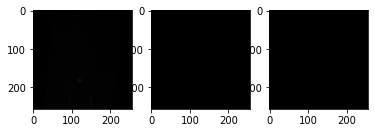

[Epoch:    1] cost = 0.639799953


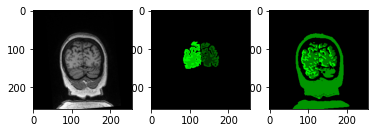

[Epoch:    2] cost = 0.584111571


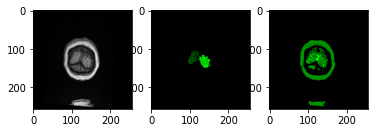

[Epoch:    3] cost = 0.566004395


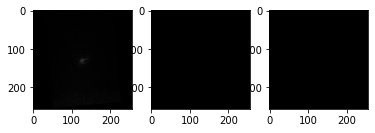

[Epoch:    4] cost = 0.581024587


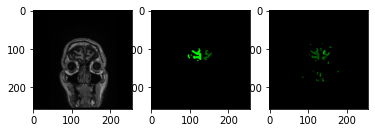

[Epoch:    5] cost = 0.505657494


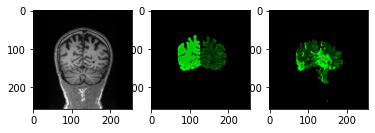

[Epoch:    6] cost = 0.461785376


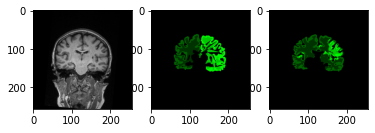

[Epoch:    7] cost = 0.435297787


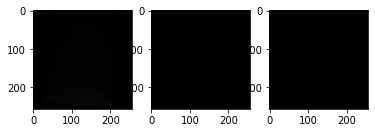

[Epoch:    8] cost = 0.595867813


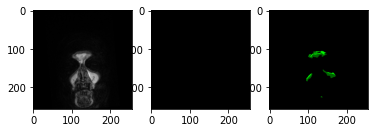

[Epoch:    9] cost = 0.623058617


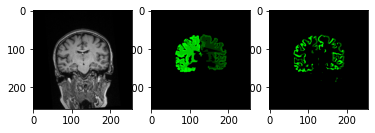

[Epoch:   10] cost = 0.585416317


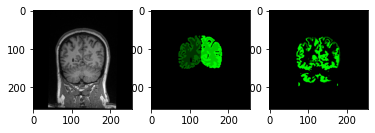

[Epoch:   11] cost = 0.58724314


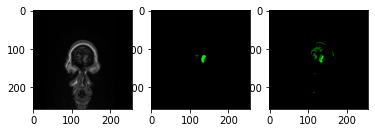

[Epoch:   12] cost = 0.582817316


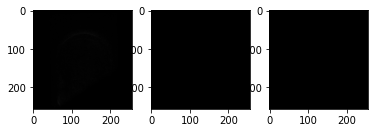

[Epoch:   13] cost = 0.565853179


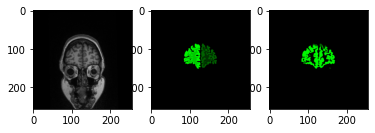

[Epoch:   14] cost = 0.559292912


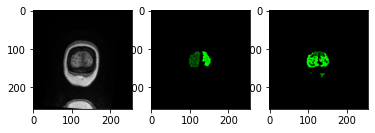

[Epoch:   15] cost = 0.554884732


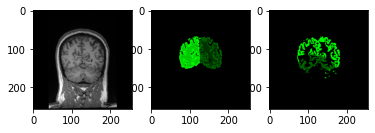

[Epoch:   16] cost = 0.553776801


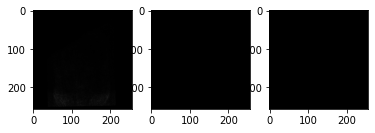

[Epoch:   17] cost = 0.545647442


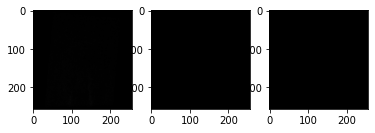

[Epoch:   18] cost = 0.546751142


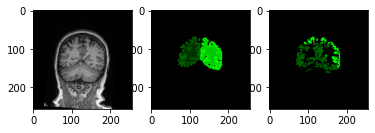

[Epoch:   19] cost = 0.539697468


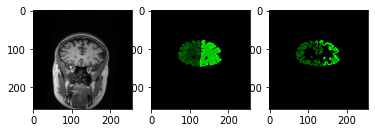

[Epoch:   20] cost = 0.535081148


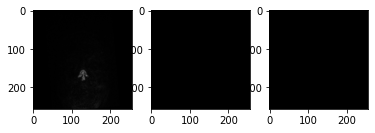

[Epoch:   21] cost = 0.533675253


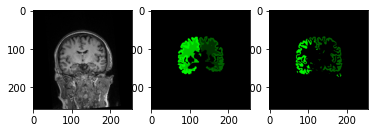

[Epoch:   22] cost = 0.528233767


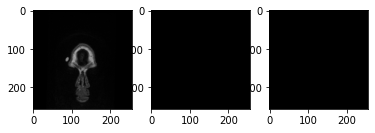

[Epoch:   23] cost = 0.525394917


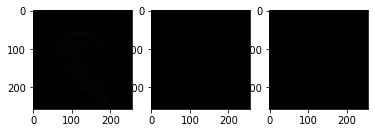

[Epoch:   24] cost = 0.517619431


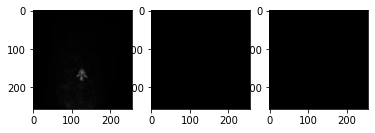

[Epoch:   25] cost = 0.509917259


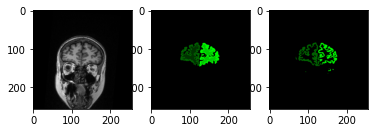

[Epoch:   26] cost = 0.515273988


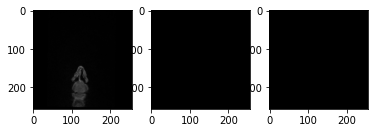

[Epoch:   27] cost = 0.517983794


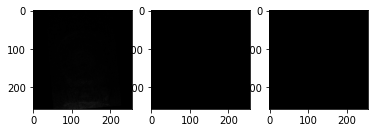

[Epoch:   28] cost = 0.428693205


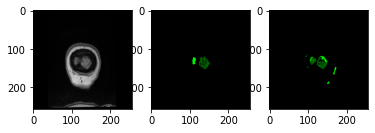

[Epoch:   29] cost = 0.393633306


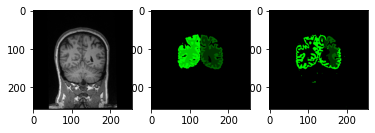

[Epoch:   30] cost = 0.352180541


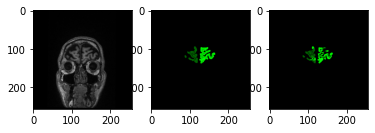

[Epoch:   31] cost = 0.353511453


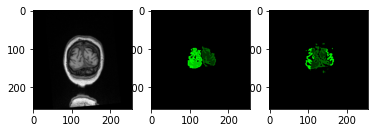

[Epoch:   32] cost = 0.289456397


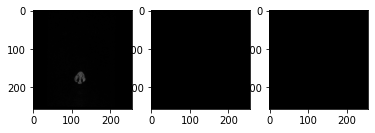

[Epoch:   33] cost = 0.415413648


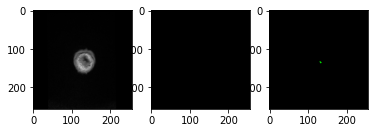

[Epoch:   34] cost = 0.26285544


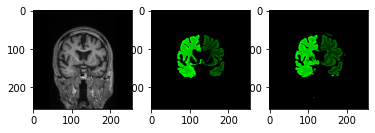

[Epoch:   35] cost = 0.228055239


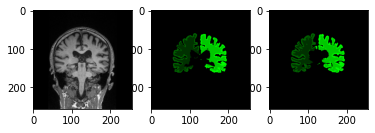

[Epoch:   36] cost = 0.203609303


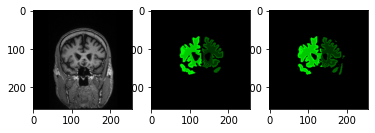

[Epoch:   37] cost = 0.2822662


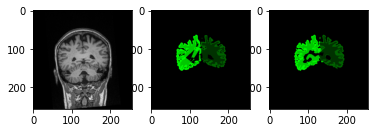

[Epoch:   38] cost = 0.197788253


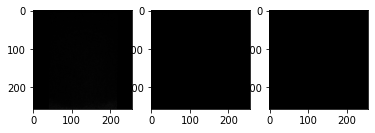

[Epoch:   39] cost = 0.177637368


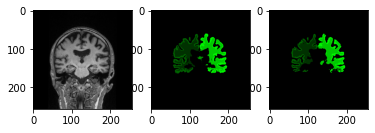

[Epoch:   40] cost = 0.193120465


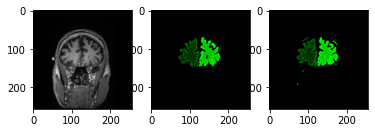

[Epoch:   41] cost = 0.177569419


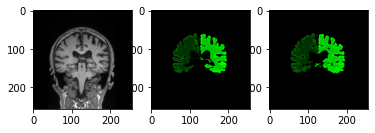

[Epoch:   42] cost = 0.178391144


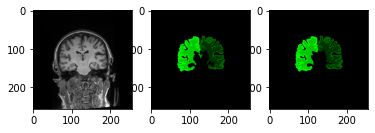

[Epoch:   43] cost = 0.166834876


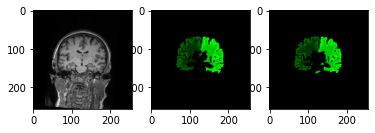

[Epoch:   44] cost = 0.15494591


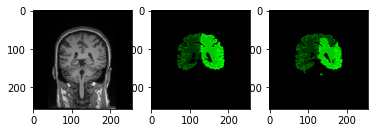

[Epoch:   45] cost = 0.351766229


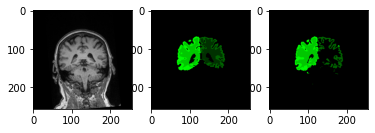

[Epoch:   46] cost = 0.311940849


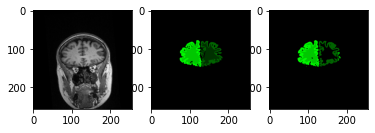

[Epoch:   47] cost = 0.310944229


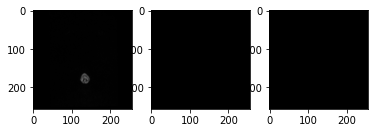

[Epoch:   48] cost = 0.302472562


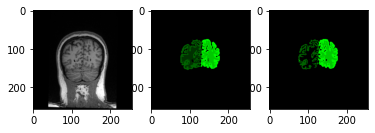

[Epoch:   49] cost = 0.305648088


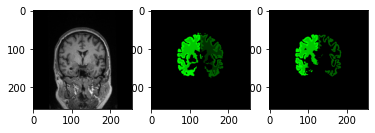

[Epoch:   50] cost = 0.30577749


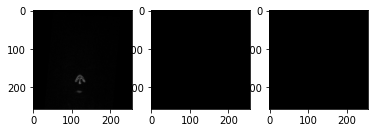

[Epoch:   51] cost = 0.308632642


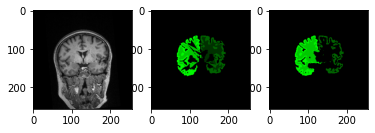

[Epoch:   52] cost = 0.306904972


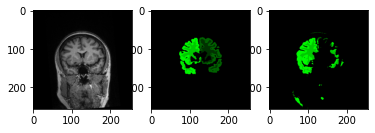

[Epoch:   53] cost = 0.23762013


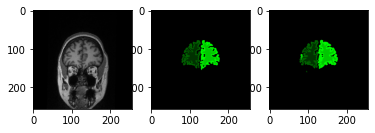

[Epoch:   54] cost = 0.201631114


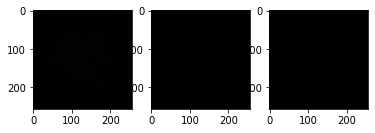

[Epoch:   55] cost = 0.153429762


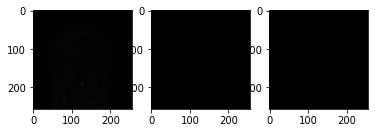

[Epoch:   56] cost = 0.18941845


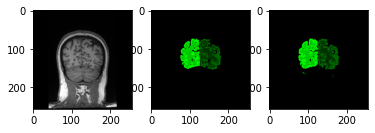

[Epoch:   57] cost = 0.149203762


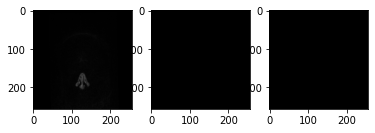

[Epoch:   58] cost = 0.153347209


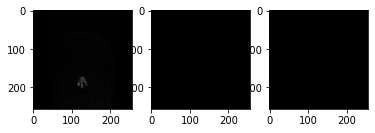

[Epoch:   59] cost = 0.187600479


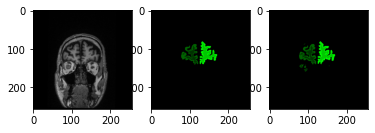

[Epoch:   60] cost = 0.148101375


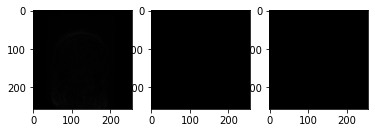

[Epoch:   61] cost = 0.147061452


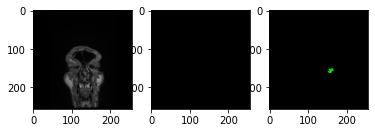

[Epoch:   62] cost = 0.170965642


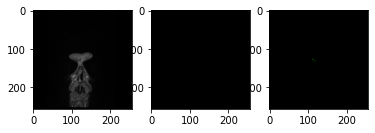

[Epoch:   63] cost = 0.150283411


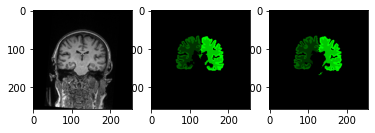

[Epoch:   64] cost = 0.1562967


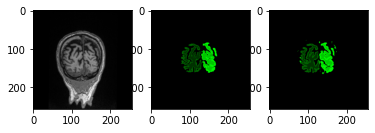

[Epoch:   65] cost = 0.207021922


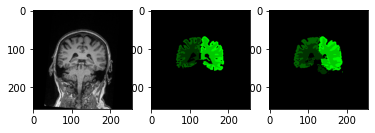

[Epoch:   66] cost = 0.171760216


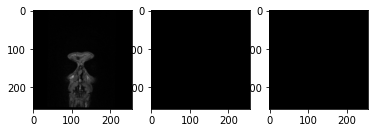

[Epoch:   67] cost = 0.146188229


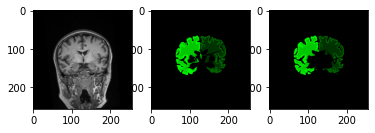

[Epoch:   68] cost = 0.165066987


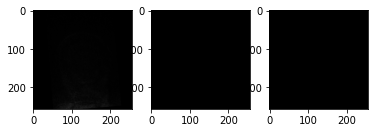

[Epoch:   69] cost = 0.189147323


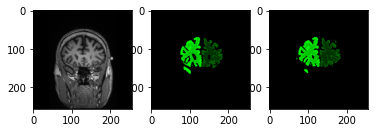

[Epoch:   70] cost = 0.149580956


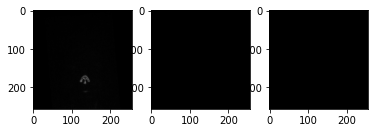

[Epoch:   71] cost = 0.147519276


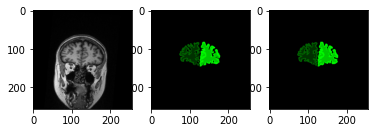

[Epoch:   72] cost = 0.136338443


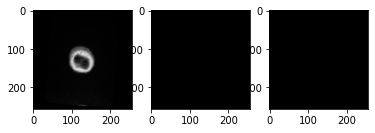

[Epoch:   73] cost = 0.128562912


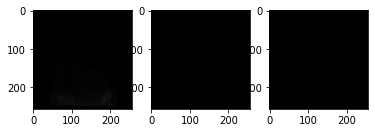

[Epoch:   74] cost = 0.136115089


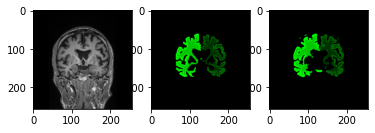

[Epoch:   75] cost = 0.142218396


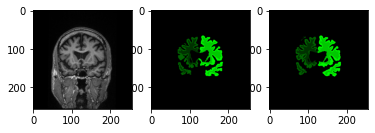

[Epoch:   76] cost = 0.141322374


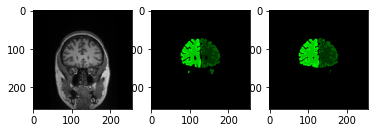

[Epoch:   77] cost = 0.150310412


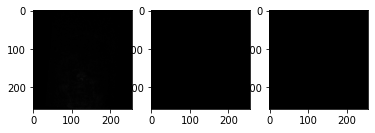

[Epoch:   78] cost = 0.142565176


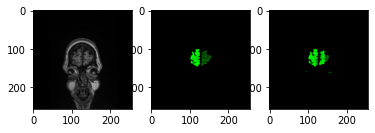

[Epoch:   79] cost = 0.13278845


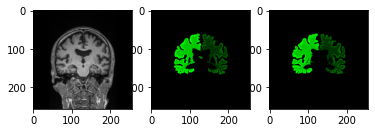

[Epoch:   80] cost = 0.147744402


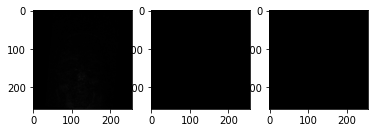

[Epoch:   81] cost = 0.151377156


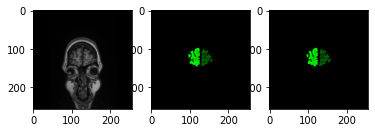

[Epoch:   82] cost = 0.135350958


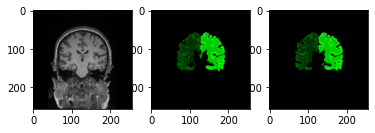

[Epoch:   83] cost = 0.133269057


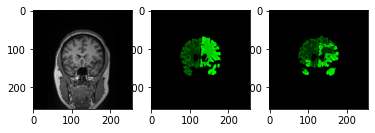

[Epoch:   84] cost = 0.142293707


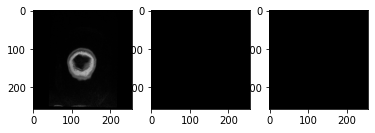

[Epoch:   85] cost = 0.131223753


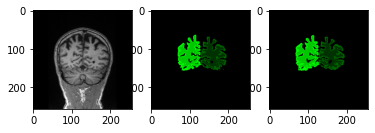

[Epoch:   86] cost = 0.133359522


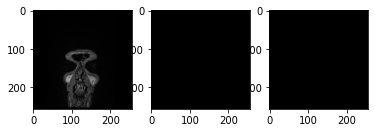

[Epoch:   87] cost = 0.137226477


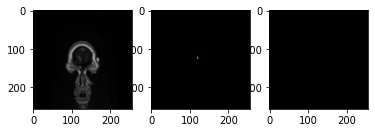

[Epoch:   88] cost = 0.131928205


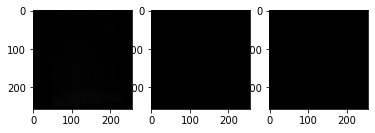

[Epoch:   89] cost = 0.148395941


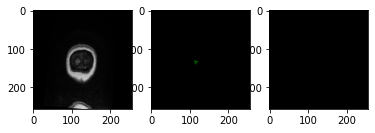

[Epoch:   90] cost = 0.135948256


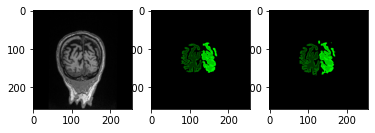

[Epoch:   91] cost = 0.138592452


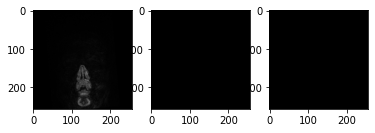

[Epoch:   92] cost = 0.128627852


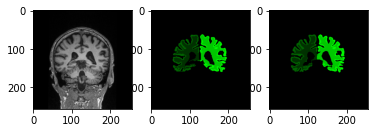

[Epoch:   93] cost = 0.124753095


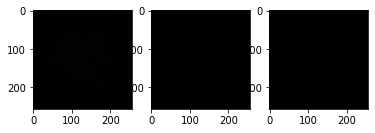

[Epoch:   94] cost = 0.122582823


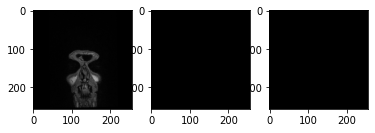

[Epoch:   95] cost = 0.125820488


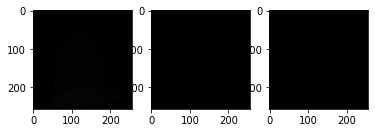

[Epoch:   96] cost = 0.130029693


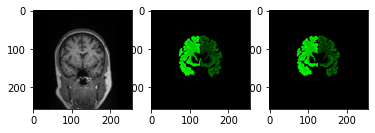

[Epoch:   97] cost = 0.12498489


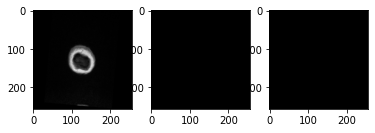

[Epoch:   98] cost = 0.19497256


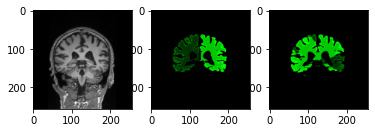

[Epoch:   99] cost = 0.138144404


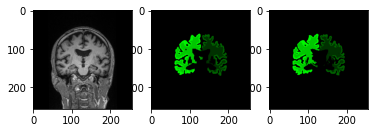

[Epoch:  100] cost = 0.127166361


In [13]:
total_batch = len(trainloader)
print('총 배치의 수 : {}'.format(total_batch))

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)

##===========================IMPORTANT!!!!!========================================================##
# 손실함수 및 최적화함수를 설정합니다.
if loss_func_switch == 0 :
    MSE_Loss2=MSE_Loss().to(device)
    loss_func = MSE_Loss2

elif loss_func_switch ==1 :
    loss_func =  nn.CrossEntropyLoss()

elif loss_func_switch ==2 :
    Dice_Loss2 = Dice_Loss().to(device)
    loss_func = Dice_Loss2 

    
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99)
optimizer =  torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = lr)# lr = learning rate

##=================================================================================================##



for i in range(num_epoch):
    avg_cost = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        x, y = data.to(device), target.squeeze().to(device=device, dtype=torch.int64)
        # x= [4,1,256,256], y= [4,256,256] , output = [4,6,256,256]
      
        optimizer.zero_grad()
        output = model.forward(x)
        
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
        
        if batch_idx==10:
            output_label = torch.argmax(output, dim=1)
            check_output(0, x.squeeze(), y, output_label, export = False)
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(i + 1, avg_cost))
    



In [14]:
#del trainloader
del x 
del y
torch.cuda.empty_cache()
ouput_list=[]
x_list=[]
y_list=[]
with torch.no_grad(): # 그레디언트 계산 안하려고 쓰는 거임 
    for batch_idx, (data, target) in enumerate(testloader):
        x, y = data.to(device), target.squeeze(0).to(device=device, dtype=torch.int64)
        # x= [1,1,256,256], y= [1,256,256] , output = [1,6,256,256]
        output = model.forward(x)
        
        output_label = torch.argmax(output, dim=1)
        # ouput_label= [1,256,256]
        ouput_list.append(output_label)
        x_list.append(x.squeeze(0))
        y_list.append(y)
    
    output_final=torch.cat(ouput_list,dim=0)
    x_final = torch.cat(x_list,dim = 0)
    y_final = torch.cat(y_list,dim = 0)
    
    num = output_final.size(0)
    
    m1 = y_final.view(num, -1)  # Flatten
    m2 = output_final.view(num, -1)  # Flatten
    
    dc_list = []
    #print('sum = ', m1.sum(), m2.sum())
    #correct_prediction = m1 == m2
    #accuracy = correct_prediction.mean()
    #print('Accuracy: ', accuracy.item())
        
    for i in range (num_class):
        if i == 0:
            dc =  DC_zero(i, m1, m2)
            dc_list.append(dc.item())
            print('dice coefficient_{}: '.format(i), dc.item())
        else :
            dc =  DC(i, m1, m2)
            dc_list.append(dc.item())
            print('dice coefficient_{}: '.format(i), dc.item())
    print('dice coefficient_mean: ', sum(dc_list)/len(dc_list))
    
#ni_img = nib.Nifti1Image(output_final.cpu(), affine=output_final.cpu())
#nib.save(ni_img, 'C:/Users/BMPL/Desktop/data set/AI_seg.nii.gz')
        


dice coefficient_0:  0.9943704009056091
dice coefficient_1:  0.8976181745529175
dice coefficient_2:  0.8247902393341064
dice coefficient_3:  0.0012594457948580384
dice coefficient_4:  0.9105684161186218
dice coefficient_5:  0.8273330330848694
dice coefficient_mean:  0.742656618298497


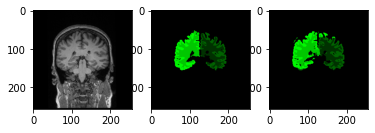

In [15]:
##==============보고싶은 레이어 넘버 입력창 ==============================##
n_layer=100
##=======================================================================##

check_output(n_layer, x_final, y_final, output_final, export = True)

In [16]:
q =np.array([[0,1,2],[0,1,2],[0,1,10]])
q2=TF.to_tensor(q).squeeze()
print(q2)
tensor = torch.zeros(3,3)
tensor2=tensor==q2

print(tensor2)

tensor([[ 0,  1,  2],
        [ 0,  1,  2],
        [ 0,  1, 10]], dtype=torch.int32)
tensor([[ True, False, False],
        [ True, False, False],
        [ True, False, False]])


In [17]:
m1 = torch.FloatTensor([[1, 2, 3], [3, 3, 4]])
m2 = torch.FloatTensor([[1, 2, 4], [2, 6,3]])
print(m1 * m2)

tensor([[ 1.,  4., 12.],
        [ 6., 18., 12.]])


In [18]:
print(10.-m1)

tensor([[9., 8., 7.],
        [7., 7., 6.]])
